In [1]:
try:
    import google.colab
    IN_COLAB = True
    from tqdm.notebook import tqdm, trange

    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    %cd /content/gdrive/MyDrive/feature-circuits
    %pip install -r requirements.txt
except:
    IN_COLAB = False
    from tqdm import tqdm, trange

import os

import torch
from nnsight import LanguageModel

from circuit import get_circuit
from circuit_plotting import plot_circuit
from dictionary_learning import AutoEncoder

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("DEVICE :", DEVICE)

print("IN_COLAB :", IN_COLAB)

DEVICE : cpu
IN_COLAB : False


In [2]:
pythia70m = LanguageModel("EleutherAI/pythia-70m-deduped", device_map=DEVICE, dispatch=True)

pythia70m_embed = pythia70m.gpt_neox.embed_in

pythia70m_resids= []
pythia70m_attns = []
pythia70m_mlps = []
for layer in range(len(pythia70m.gpt_neox.layers)):
    pythia70m_resids.append(pythia70m.gpt_neox.layers[layer])
    pythia70m_attns.append(pythia70m.gpt_neox.layers[layer].attention)
    pythia70m_mlps.append(pythia70m.gpt_neox.layers[layer].mlp)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
path = "C:/Users/Grégoire/Documents/ENS/stages/AttentionGraph/Marks/"
if not os.path.exists(path) and IN_COLAB:
    path = "/content/gdrive/MyDrive/"
    %cd dictionary_learning/
    !apt-get update
    !apt-get install dos2unix
    !dos2unix pretrained_dictionary_downloader.sh
    !chmod +x pretrained_dictionary_downloader.sh
    !./pretrained_dictionary_downloader.sh
    %cd /content/gdrive/MyDrive/feature-circuits

path += 'feature-circuits/dictionary_learning/dictionaires/pythia-70m-deduped/'

dictionaries = {}

d_model = 512
dict_size = 32768

ae = AutoEncoder(d_model, dict_size).to(DEVICE)
ae.load_state_dict(torch.load(path + f"embed/ae.pt", map_location=DEVICE))
dictionaries[pythia70m_embed] = ae


for layer in range(len(pythia70m.gpt_neox.layers)):
    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(torch.load(path + f"resid_out_layer{layer}/ae.pt", map_location=DEVICE))
    dictionaries[pythia70m_resids[layer]] = ae

    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(torch.load(path + f"attn_out_layer{layer}/ae.pt", map_location=DEVICE))
    dictionaries[pythia70m_attns[layer]] = ae

    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(torch.load(path + f"mlp_out_layer{layer}/ae.pt", map_location=DEVICE))
    dictionaries[pythia70m_mlps[layer]] = ae

In [4]:
def metric_fn_v1(model, trg=None):
    """
    default : return the logit
    """
    if trg is None:
        raise ValueError("trg must be provided")
    logits = model.embed_out.output[:,-1,:]
    return logits[torch.arange(trg.numel()), trg]

def metric_fn_v2(model, trg=None):
    """
    Return -log probability for the expected target.

    trg : torch.Tensor, contains idxs of the target tokens (between 0 and d_vocab_out)

    /!\ here we assume that all last tokens are indeed in the last position (if padding, it must happen in front of the sequence, not after)
    """
    if trg is None:
        raise ValueError("trg must be provided")
    logits = model.embed_out.output[:,-1,:]
    return (
         -1 * torch.gather(
             torch.nn.functional.log_softmax(model.embed_out.output[:,-1,:], dim=-1),
             dim=-1, index=trg.view(-1, 1)
         ).squeeze(-1)
    )

In [5]:
batch_size = 1

clean = [
    "When Mary and John went to the store, John gave a drink to"
    for _ in range(batch_size)
]
patch = None

trg = " Mary"
trg_idx = torch.tensor([pythia70m.tokenizer.encode(trg)[0]] * batch_size, device=DEVICE)
print(trg_idx)

tensor([6393])


In [6]:
circuit = get_circuit(
    clean, patch,
    pythia70m,
    pythia70m_embed, pythia70m_attns, pythia70m_mlps, pythia70m_resids, dictionaries,
    metric_fn_v1, {"trg": trg_idx}
)

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


KeyboardInterrupt: 

torch.Size([32768])


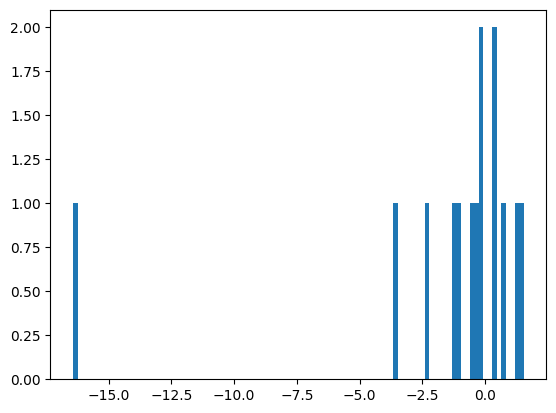

tensor(-21.5079)


In [ ]:
embed_weights = circuit[0]["embed"]

print(embed_weights.act.shape)
from matplotlib import pyplot as plt
plt.hist(embed_weights.act[embed_weights.act.abs() > 0.05].detach().cpu().numpy(), bins=100)
plt.show()
print(sum(embed_weights.act))

In [ ]:
import importlib
import circuit_plotting
importlib.reload(circuit_plotting)
circuit_plotting.plot_circuit(circuit[0], circuit[1], save_dir='./saved_circuits')

ImportError: requires pygraphviz http://pygraphviz.github.io/

torch.Size([146400])
tensor(0.0037)


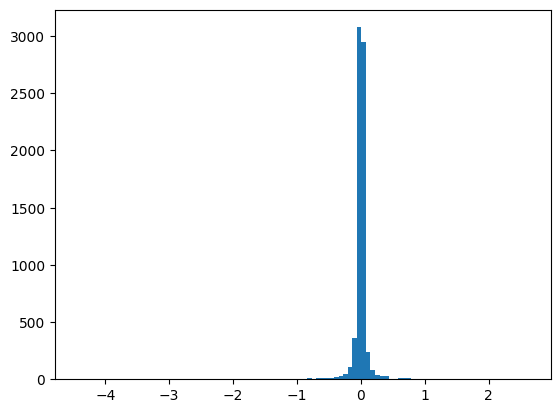

In [ ]:
all_weights = []
for key, value in circuit[1].items():
    for k, v in value.items():
        all_weights.append(v.values())
        
all_weights = torch.cat(all_weights, dim=0)
print(all_weights.shape)
print(all_weights.abs().mean())

plt.hist(all_weights[all_weights.abs() > 0.01].detach().cpu().numpy(), bins=100)
plt.show()